# VarClump1D: Concept test
## _Variating $c$ and $\sigma$ independently..._

In [1]:
%matplotlib inline

import sys
import numpy as np
import scipy as sp
import sympy as sym
import numexpr as ne
import matplotlib.pyplot as plt
from scipy import interpolate, optimize

#import of acalib helper functions
sys.path.append('../../ACALIB/')
from acalib import acontainer as ac

## Helper functions

In [2]:
"""
Helper functions to visualize the quality of the solution
"""
def compare_plot(c, sig, xc, resolution=10, title=None, log=False):
    _xe = np.linspace(0., 1., 10*N, endpoint=True)
    _Dx = np.empty((10*N,N))
    for k in range(10*N):
        _Dx[k,:] = (_xe[k] - xc)

    phi_m = phi(_Dx, sig)
    u = np.dot(phi_m, c)
    plt.figure(figsize=(10,6))
    plt.plot(_xe, u, 'r-', label='Solution')
    plt.plot(x_, f(x_), 'b--', label='Data')
    plt.plot(xe, f(xe), 'go', label='Evaluation points')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.3, 1.0))
    plt.show()

def compare_plot_log(c, sig, xc, resolution=10, title=None):
    _xe = np.linspace(0., 1., 10*N, endpoint=True)
    _Dx = np.empty((10*N,N))
    for k in range(10*N):
        _Dx[k,:] = (_xe[k] - xc)

    phi_m = phi(_Dx, sig)
    u = np.dot(phi_m, c)
    plt.figure(figsize=(10,6))
    plt.semilogy(_xe, np.abs(u-f(_xe)), 'r-')
    plt.title(title)
    plt.show()

## Variational Model

Given the following functional: 

$$J(u) = \int_{\Omega \subset \mathbb{R}} L(x, u, u_x) \ dx  = \int_{\Omega \subset \mathbb{R}}(u(x)-f_0(x))^2 + \alpha \ \Psi_1(u(x)-f_0(x)) + \beta \ \Psi_2(|u_x(x)|) \ dx $$

then when we try to minimize it, the corresponding Euler-Lagrange equation becomes:

$$\frac{\partial L}{\partial u}-\frac{d}{dx}\frac{\partial L}{\partial u_x} =  2(u(x)-f_0(x)) + \alpha \ \Psi_1'(u(x)-f_0(x)) - \beta \ u_{xx}(x) \ \Psi_2''(|u_{x}(x)|) = 0$$

whit boundary condition $u(\partial \Omega) = 0$. The proposed solution has the form of a linear combination of Gaussian functions:

$$u(x) = \sum_{i=1}^N c_i \ \phi(x; x_i, \sigma_i) = \sum_{i=1}^N c_i \ e^{-\frac{(x-x_i)^2}{2 \sigma_i^2}}$$

## Loading data 1D from center pixel of cube

In [3]:
"""
Loading data
"""
cont = ac.AContainer()
#cont.load('../../bindata/fits/cubes/Antennae_North.CO3_2Line.Clean.pcal1.image.fits')
#cont.load('../../bindata/fits/cubes/Antennae_South.CO3_2Line.Clean.pcal1.image.fits')
#cont.load('../../bindata/fits/cubes/CenA.CO2_1Line.Clean.image.fits')
cont.load('../../bindata/fits/cubes/M100line.image.fits')
#cont.load('../../bindata/fits/cubes/Orion.methanol.cbc.contsub.image.fits')

cube = cont.primary
spar = cube.standarize()
data = cube.data

INFO: Processing HDU 0 (Image) [acalib.io.formats]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.formats]


/home/martin/miniconda2/lib/python2.7/site-packages/numpy/ma/core.py:809: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


In [4]:
"""
Generating the data function
"""
f_data = data[:,300,300]
f_data /= np.max(f_data)
x = np.linspace(0., 1., len(f_data), endpoint=True)
f = sp.interpolate.interp1d(x, f_data, kind='linear')
x_ = np.linspace(0., 1., 10*len(f_data), endpoint=True)

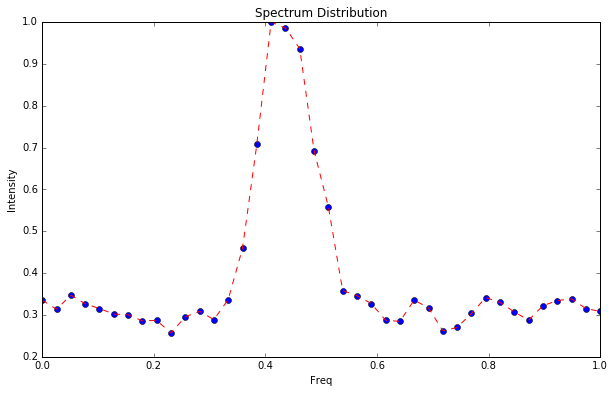

In [5]:
plt.figure(figsize=(10,6))
plt.plot(x, f_data, 'bo', x_, f(x_), 'r--')
plt.title('Spectrum Distribution')
plt.xlabel('Freq')
plt.ylabel('Intensity')
plt.show()

## Defining and computing the penalizing functions $\Psi_1$ and $\Psi_2$

In [6]:
z = sym.Symbol('z')

#Penalizing function and its derivatives
#psi1 = sym.exp(z)
#d1psi1 = sym.diff(psi1, z)
#d1psi1 = sym.lambdify(z, d1psi1, modules='numpy')
def d1psi1(x, scale=10.):
    x = scale*x
    ret = np.empty(x.shape)
    mask0 = x<=0.
    mask1 = x>=1.
    mask01 = np.logical_and(np.logical_not(mask0),np.logical_not(mask1))
    ret[mask0] = 0.
    ret[mask1] = 1.
    #evaluation on 0-1
    x = x[mask01]
    ret[mask01] = ne.evaluate('(4*(x-1)*x+2) / (4*(x-1)**2 * x**2 * (cosh(1/x + 1/(x-1))+1))')
    return ret
    

#Smoothing function and its derivatives
#lamb = 0.5
#psi2 = 2*lamb*sym.log(1 + z**2/lamb)
psi2 = z**3
d1psi2 = sym.diff(psi2, z)
d2psi2 = sym.diff(d1psi2, z)
d1psi2 = sym.lambdify(z, d1psi2, modules='numpy')
d2psi2 = sym.lambdify(z, d2psi2, modules='numpy')

## $\phi$-RBF function to use and its derivatives

In [7]:
#minimal broadening of gaussians
minsig = 0.001

"""
RBF (Gaussian) functions and its derivatives
"""
def phi(x, sig, minsig=0.):
    retval = ne.evaluate('exp(-x**2/(2*(minsig**2+sig**2)))')
    #retval = np.exp(-x**2/(2*sig**2))
    return retval

def phix(x, sig, minsig=0.):
    retval = ne.evaluate('-(1./(minsig**2+sig**2)) * exp(-x**2/(2*(minsig**2+sig**2))) * x')
    #retval = -(1./sig**2) * np.exp(-x**2/(2*sig**2)) * x
    return retval

def phixx(x, sig, minsig=0.):
    retval = ne.evaluate('(1./(minsig**2+sig**2)**2) * exp(-x**2/(2*(minsig**2+sig**2))) * (x**2 - minsig**2 - sig**2)')
    #retval = (1./sig**4) * np.exp(-x**2/(2*sig**2)) * (x**2 - sig**2)
    return retval

## Euler-Lagrange Function class definition

In [8]:
class ELFunc():
    def __init__(self, f, xe, xc, c0, sig0, d1psi1, d2psi2, a=0., b=0.):
        #data function at evaluation and boundary points
        f0 = f(xe)
        fb = [f(0),f(1)]
        
        len_f0 = len(f0)
        len_xe = len(xe)
        len_xc = len(xc); N = len_xc;
        len_c0 = len(c0)
        len_sig0 = len(sig0)
        """
        TODO:verify consistency
        """
        #if len_c0 != len_sig0: 
        #    print('Dimensions of c0 and sig0 must match!')
        #    return None
        #if (shape_Dx[0]+2 != shape_Dx[1]) or (shape_Dx[1] != len_c0):
        #    print('Dimensions of Dx are wrong!')
        #    return None
        """ 
        Computing distance matrix.
        Note: Evaluation and collocation points will be the same
        """
        Dx = np.empty((2*N-2,N))
        for i in range(2*N-2):
            Dx[i,:] = (xe[i] - xc)
        
        self.f0 = f0
        self.fb = fb
        self.xe = xe
        self.xc = xc
        self.Dx = Dx
        self.c = c0
        self.sig = sig0
        self.phi_m   = phi(Dx,sig0)
        self.phix_m  = phix(Dx,sig0)
        self.phixx_m = phixx(Dx,sig0)
        self.d1psi1 = d1psi1
        self.d2psi2 = d2psi2
        self.a = a
        self.b = b
    
    def set_c(self, c):
        self.c = c
    
    def set_sig(self, sig):
        self.sig = sig
        self.phi_m   = phi(self.Dx,sig)
        self.phix_m  = phix(self.Dx,sig)
        self.phixx_m = phixx(self.Dx,sig)
        
    """
    Function to optimize c parameters
    """
    def F1(self, c):
        #computing the Euler-Lagrange equation
        u   = np.dot(self.phi_m, c)
        ux  = np.dot(self.phix_m, c)
        uxx = np.dot(self.phixx_m, c)
        el  = 2.*(u-self.f0) + self.a*self.d1psi1(u-self.f0) - self.b*uxx*self.d2psi2(np.abs(ux))

        #evaluating at boundary
        bc = [np.dot(phi(-self.xc,self.sig),c)-self.fb[0], 
              np.dot(phi(1.-self.xc,self.sig),c)-self.fb[-1]]
        #bc = [np.dot(phi(-self.xc,sig),c), np.dot(phi(1.-self.xc,sig),c)]
        #bc = [np.dot(phix(-self.xc,sig),c), np.dot(phix(1.-self.xc,sig),c)]
        #print(u); print(ux); print(uxx)
        return np.concatenate([el,bc])

    """
    Function to optimize sig parameters
    """
    def F2(self, sig):    
        #phi function's evaluation
        phi_m   = phi(self.Dx, sig)
        phix_m  = phix(self.Dx, sig)
        phixx_m = phixx(self.Dx, sig)

        #computing the Euler-Lagrange equation
        u   = np.dot(phi_m, self.c)
        ux  = np.dot(phix_m, self.c)
        uxx = np.dot(phixx_m, self.c)
        el = 2.*(u-self.f0) + self.a*self.d1psi1(u-self.f0) - self.b*uxx*self.d2psi2(np.abs(ux))

        #evaluating at boundary
        bc = [np.dot(phi(-self.xc,sig),self.c)-self.fb[0], 
              np.dot(phi(1.-self.xc,sig),self.c)-self.fb[-1]]
        #bc = [np.dot(phi(-self.xc,sig),c), np.dot(phi(1.-self.xc,sig),c)]
        #bc = [np.dot(phix(-self.xc,sig),c), np.dot(phix(1.-self.xc,sig),c)]
        return np.concatenate([el,bc])

## Center and evaluation points

In [9]:
#number of gaussians
N = 20

""" Computing center points """
xc = np.linspace(0., 1., N+2, endpoint=True)[1:-1]
print('Center points:')
print(xc)
print('---------------------------------------------')

""" 
Computing evaluation points, i.e, points where
EL equation will be evaluated
"""
xe = np.linspace(0., 1., 2*N, endpoint=True)[1:-1]
print('Evaluation points:')
print(xe)
print('---------------------------------------------')

Center points:
[ 0.04761905  0.0952381   0.14285714  0.19047619  0.23809524  0.28571429
  0.33333333  0.38095238  0.42857143  0.47619048  0.52380952  0.57142857
  0.61904762  0.66666667  0.71428571  0.76190476  0.80952381  0.85714286
  0.9047619   0.95238095]
---------------------------------------------
Evaluation points:
[ 0.02564103  0.05128205  0.07692308  0.1025641   0.12820513  0.15384615
  0.17948718  0.20512821  0.23076923  0.25641026  0.28205128  0.30769231
  0.33333333  0.35897436  0.38461538  0.41025641  0.43589744  0.46153846
  0.48717949  0.51282051  0.53846154  0.56410256  0.58974359  0.61538462
  0.64102564  0.66666667  0.69230769  0.71794872  0.74358974  0.76923077
  0.79487179  0.82051282  0.84615385  0.87179487  0.8974359   0.92307692
  0.94871795  0.97435897]
---------------------------------------------


## Initial conditions

In [10]:
"""
Defining initial parameter values
"""
c0 = f(xc)/N
sig0 = (1./(N))*np.ones(N)

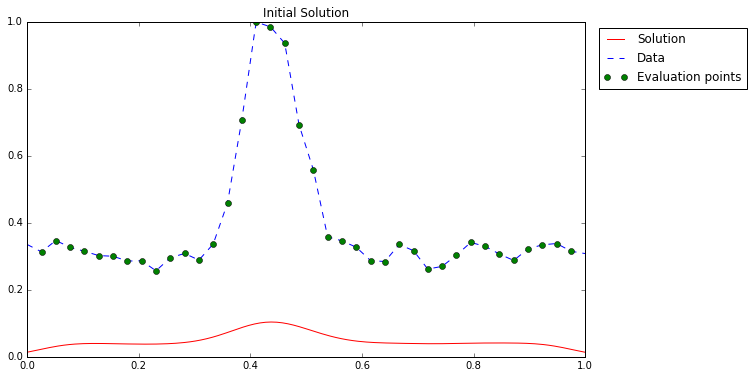

In [11]:
"""
Visualizing the 'initial' solution
"""
compare_plot(c0, sig0, xc, title='Initial Solution')

## Solving it!

In [12]:
"""
Solve function
"""
def solve(elf, n_iter=3, verbose=True):
    for i in range(n_iter):
        #solve for c
        sol = sp.optimize.root(elf.F1, elf.c, method='lm')
        opt_c = sol.x
        delta_c = np.linalg.norm(opt_c-elf.c)
        elf.set_c(opt_c)
        title = 'Best solution at iter={0} and improved c'.format(i)
        compare_plot(elf.c, elf.sig, elf.xc, title=title)
        print('Variation on c='+str(delta_c))
        print('------------------------------------------------------------')

        #solve for sig
        sol = sp.optimize.root(elf.F2, elf.sig, method='lm')
        opt_sig = sol.x
        delta_sig = np.linalg.norm(opt_sig-elf.sig)
        elf.set_sig(opt_sig)
        title = 'Best solution at iter={0} and improved sig'.format(i)
        compare_plot(elf.c, elf.sig, elf.xc, title=title)
        print('Variation on sig='+str(delta_sig))
        print('-------------------------------------------------------------')

In [13]:
"""
Instantiating the EL func object
"""
elf1 = ELFunc(f, xe, xc, c0, sig0, d1psi1, d2psi2, a=0., b=0.)
elf2 = ELFunc(f, xe, xc, c0, sig0, d1psi1, d2psi2, a=1., b=0.0001)

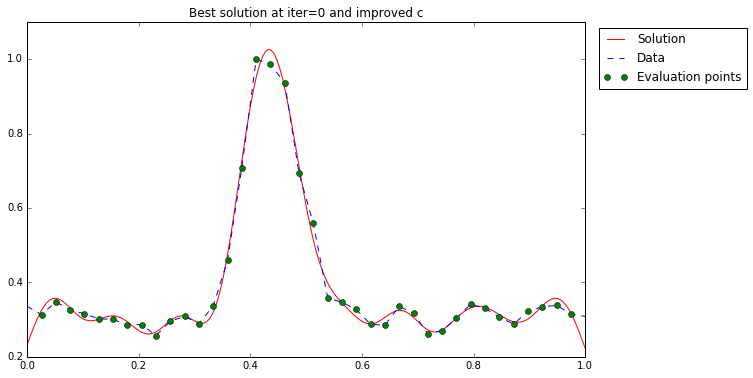

Variation on c=1.35508817362
------------------------------------------------------------


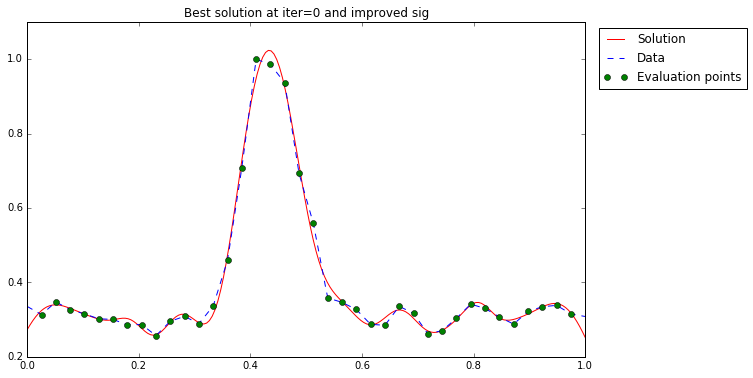

Variation on sig=0.0512258665041
-------------------------------------------------------------


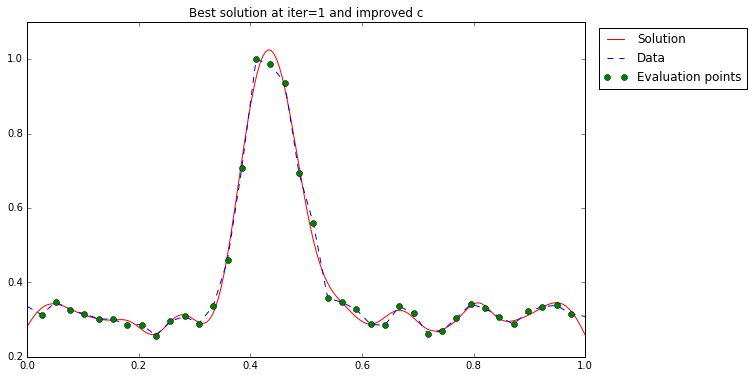

Variation on c=0.184714268656
------------------------------------------------------------


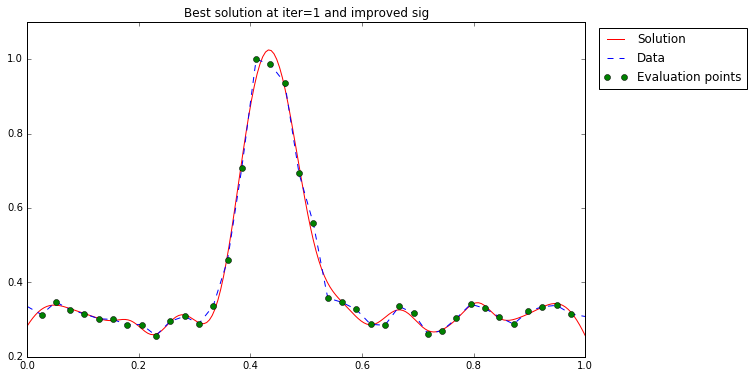

Variation on sig=0.015908760646
-------------------------------------------------------------


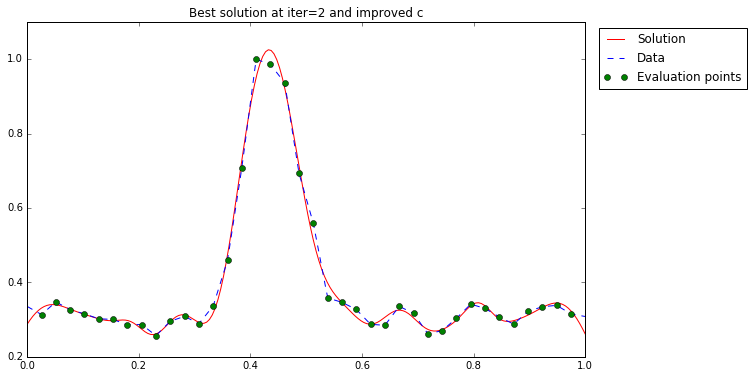

Variation on c=0.0836351469656
------------------------------------------------------------


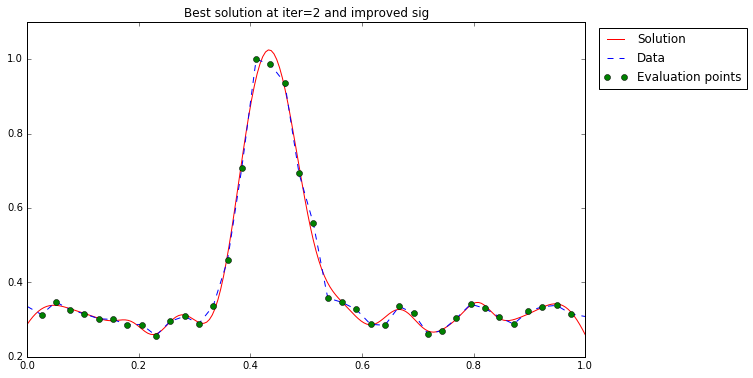

Variation on sig=0.0156120272158
-------------------------------------------------------------


In [14]:
solve(elf1)

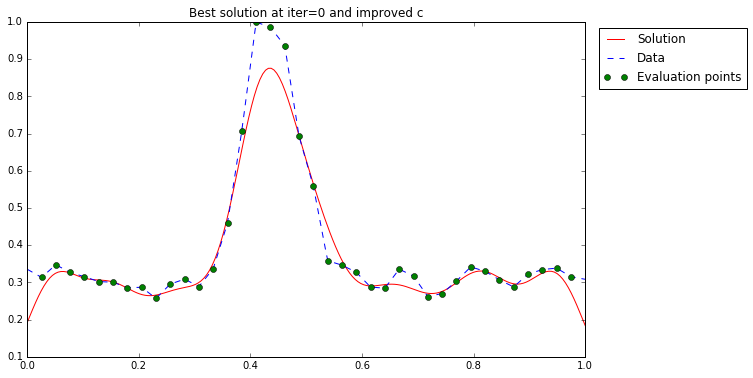

Variation on c=0.858240974631
------------------------------------------------------------


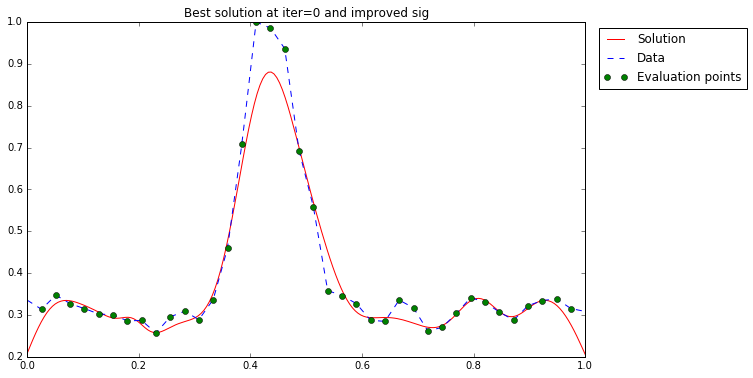

Variation on sig=0.0627999490699
-------------------------------------------------------------


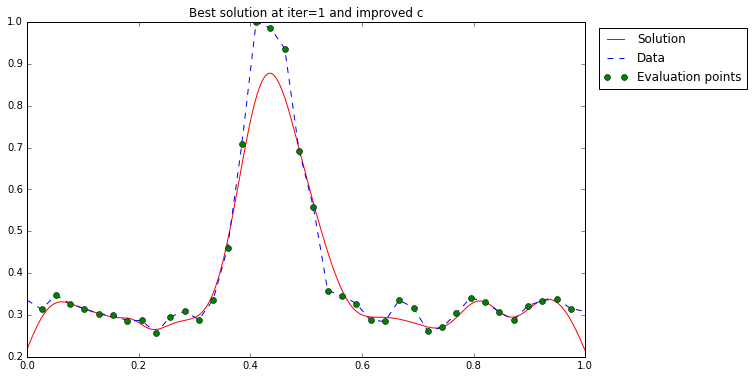

Variation on c=0.0865131070298
------------------------------------------------------------


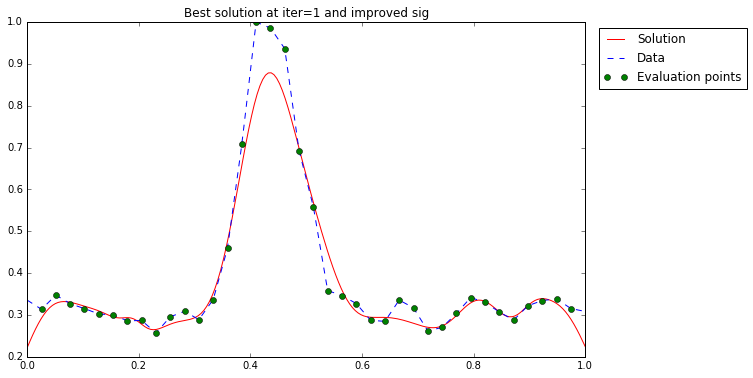

Variation on sig=0.0413994475997
-------------------------------------------------------------


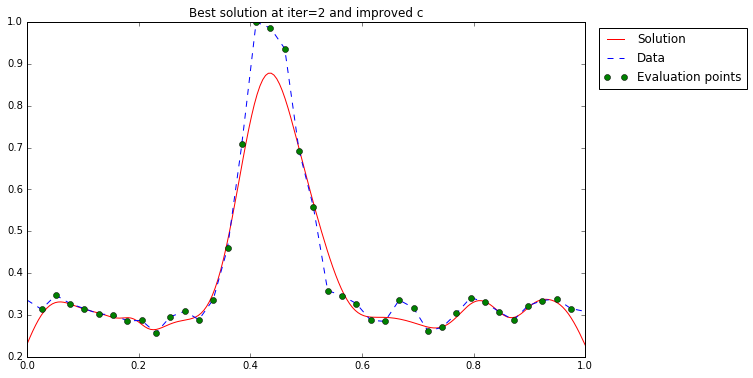

Variation on c=0.0584093111479
------------------------------------------------------------


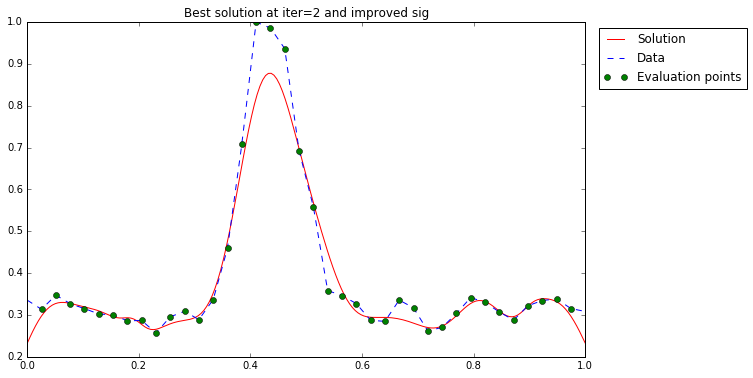

Variation on sig=0.00890286607484
-------------------------------------------------------------


In [15]:
solve(elf2)